<a href="https://colab.research.google.com/github/lavatus/CS114.L21/blob/main/Copy_of_Sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NHẬN DIỆN TIN CHÂM BIẾM QUA TIÊU ĐỀ CÁC BÀI BÁO :** 

### **Các thành viên trong nhóm** :
* Nguyễn Trung Tuấn -19522477
* Dương Nguyễn Thuận - 19522312
* Nguyễn Việt Thư - 19522309


## **I. Import các thư viện cần thiết :**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords, brown
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import plotly.graph_objs as go
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## **II. Đọc dữ liệu**

* Dữ liệu đã được crawl sẵn trên github chỉ cần up lên và sử dụng [Data](https://github.com/lavatus/CS114.L21/tree/main/Assignments/Sarcasm%20detection%20in%20news%20headline/File%20json)
* Code thu thập dữ liệu [Code](https://github.com/lavatus/CS114.L21/tree/main/Assignments/Sarcasm%20detection%20in%20news%20headline/Colab%20File)

In [ ]:
import pandas as pd
bestAu = pd.read_json('/content/0_BestInAu.json', lines =True )
NBC = pd.read_json('/content/0_NBCNews.json')
citynews = pd.read_json('/content/0_citynews.json', lines =True )
babylon = pd.read_json('/content/1_babylonbee.json')
clickhole =  pd.read_json('/content/1_clickhole.json')
thebeaverton =  pd.read_json('/content/1_thebeaverton.json')
thepoke = pd.read_json('/content/1_thepoke.json')
data = pd.concat([bestAu, NBC, citynews, babylon, clickhole, thebeaverton, thepoke])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86408 entries, 0 to 12609
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  86408 non-null  object
 1   headline      86408 non-null  object
 2   is_sarcastic  86408 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


In [ ]:
data['is_sarcastic'].value_counts()

0    62930
1    23478
Name: is_sarcastic, dtype: int64

###**Nhận xét :**
* Nhóm thu thâp được tổng cộng 86408 bài báo. Trong đó có: 
  + 62930 bài báo chính thống
  + 23478 bài báo không chính thống
* Số lượng báo chính thống gấp hơn 3 lần so với báo châm biếm. 
* Có thể dễ dàng nhìn thấy dữ liệu của chúng ta bị mất cân bằng, điều này dẫn đến accuracy của model có thể thấp và việc dự đoán sẽ dễ bị lệch về chính thống hơn.

## **III. Tiền xử lý dữ liệu :**

In [ ]:
X = data["headline"].values
y = data["is_sarcastic"].values

### **1. Tạo vocalbulary theo data đã thu thập :**

In [ ]:
stop_words = set(stopwords.words('english')) # Vd: a, an ,is ,...

In [ ]:
# tập các từ tiếng Anh của thư viện nltk
corpora_nltk = brown.words(categories='news')

In [ ]:

def preprocessing(text): # Loại bỏ các kí tự không phải alphabet, chuyển sang chữ thường, loại bỏ các stop word
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in text]
  words = [word for word in stripped if word.isalpha()]

  words = [w for w in words if not w in stop_words]

  vocabulary = [w.lower() for w in words]
  vocabulary = list(dict.fromkeys(vocabulary))
  return vocabulary

In [ ]:
corpora_nltk = preprocessing(corpora_nltk)

### **2. Chia train, test :**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

In [ ]:
print("X_train size : " + str(X_train.shape))
print("X_test size : " + str(X_test.shape))

X_train size : (64806,)
X_test size : (21602,)


### **3. Dùng CountVectorizer để vectorize (đếm số lần xuất hiện) :**


* Hàm trả về ma trận scipy.sparse.csr.csr_matrix lưu trữ vị trí của từ đó trong từ điển và số lần xuất hiện trong câu :

In [ ]:
vectorizer_CV = CountVectorizer(stop_words = stop_words, vocabulary = corpora_nltk, strip_accents = 'ascii')
vectorizer_CV.fit(X_train)

X_train_CV = vectorizer_CV.transform(X_train)
X_test_CV  = vectorizer_CV.transform(X_test)
print(X_train_CV.shape)

(64806, 12085)


### **4. Dùng TF-IDF:**

In [ ]:
vectorizer_TF = TfidfVectorizer(stop_words = stop_words, vocabulary = corpora_nltk, strip_accents = 'ascii')
vectorizer_TF.fit(X_train)

X_train_TF = vectorizer_TF.transform(X_train)
X_test_TF  = vectorizer_TF.transform(X_test)
print(X_train_TF.shape)

(64806, 12085)


## **IV. Train model:**

* Chúng em sử dụng nhiều thuật toán máy học khác nhau cho bài toán phân lớp này để có thể chọn được thuật toán có accuracy cao nhất.

### **1. Support vector machine (SVM)**

* SVM với Count Vectorizer :

In [ ]:
classifier_SVM_CV = LinearSVC().fit(X_train_CV, y_train)
score_SVM_CV = classifier_SVM_CV.score(X_test_CV, y_test)

In [ ]:
y_pred = classifier_SVM_CV.predict(X_test_CV)
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     15665
           1       0.80      0.72      0.76      5937

    accuracy                           0.87     21602
   macro avg       0.85      0.82      0.84     21602
weighted avg       0.87      0.87      0.87     21602



In [ ]:
confusion_matrix(y_test, y_pred, normalize= 'true')

array([[0.93405681, 0.06594319],
       [0.28482399, 0.71517601]])

* SVM với TF-IDF Vectorizer:

In [ ]:
classifier_SVM_TF = LinearSVC().fit(X_train_TF, y_train)
score_SVM_TF = classifier_SVM_TF.score(X_test_TF, y_test)

In [ ]:
y_pred = classifier_SVM_TF.predict(X_test_TF)
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     15665
           1       0.82      0.71      0.76      5937

    accuracy                           0.88     21602
   macro avg       0.86      0.83      0.84     21602
weighted avg       0.88      0.88      0.88     21602



In [ ]:
confusion_matrix(y_test, y_pred, normalize= 'true')

array([[0.941015  , 0.058985  ],
       [0.28735051, 0.71264949]])

### **2. Logistic Regression**

* Logistic Regression với Count Vectorizer:

In [ ]:
classifier_LR_CV = LogisticRegression().fit(X_train_CV, y_train)
score_LR_CV = classifier_LR_CV.score(X_test_CV, y_test)

In [ ]:
y_pred = classifier_LR_CV.predict(X_test_CV)
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     15665
           1       0.84      0.70      0.76      5937

    accuracy                           0.88     21602
   macro avg       0.87      0.82      0.84     21602
weighted avg       0.88      0.88      0.88     21602



In [ ]:
confusion_matrix(y_test, y_pred, normalize= 'true')

array([[0.94873923, 0.05126077],
       [0.29930942, 0.70069058]])

* Logistic Regression với TF-IDF Vectorizer:

In [ ]:
classifier_LR_TF = LogisticRegression().fit(X_train_TF, y_train)
score_LR_TF = classifier_LR_TF.score(X_test_TF, y_test)

In [ ]:
y_pred = classifier_LR_TF.predict(X_test_TF)
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     15665
           1       0.87      0.66      0.75      5937

    accuracy                           0.88     21602
   macro avg       0.87      0.81      0.83     21602
weighted avg       0.88      0.88      0.87     21602



In [ ]:
confusion_matrix(y_test, y_pred, normalize= 'true')

array([[0.96157038, 0.03842962],
       [0.34360788, 0.65639212]])

### **3. K-Neighbors Classifier**

* K-Neighbors classifier với Count Vectorizer:

In [ ]:
classifier_KNC_CV = KNeighborsClassifier(n_neighbors=3)
classifier_KNC_CV.fit(X_train_CV, y_train)
score_KNC_CV = classifier_KNC_CV.score(X_test_CV, y_test)

In [ ]:
y_pred = classifier_KNC_CV.predict(X_test_CV)
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     15665
           1       0.57      0.54      0.56      5937

    accuracy                           0.76     21602
   macro avg       0.70      0.69      0.70     21602
weighted avg       0.76      0.76      0.76     21602



In [ ]:
confusion_matrix(y_test, y_pred, normalize= 'true')

array([[0.84596234, 0.15403766],
       [0.4574701 , 0.5425299 ]])

* K-Neighbors classifier với TF-IDF Vectorizer:

In [ ]:
classifier_KNC_TF = KNeighborsClassifier(n_neighbors=2)
classifier_KNC_TF.fit(X_train_TF, y_train)
score_KNC_TF = classifier_KNC_TF.score(X_test_TF, y_test)

In [ ]:
y_pred = classifier_KNC_TF.predict(X_test_TF)
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86     15665
           1       0.86      0.19      0.31      5937

    accuracy                           0.77     21602
   macro avg       0.81      0.59      0.59     21602
weighted avg       0.79      0.77      0.71     21602



In [ ]:
confusion_matrix(y_test, y_pred, normalize= 'true')

array([[0.9881264 , 0.0118736 ],
       [0.81084723, 0.18915277]])

### **4. So sánh các model với bộ dữ liệu train test chia ra từ 6 trang thu thập được**

Running Linear SVM
[0.87363061 0.86545286 0.8745564  0.8742478  0.87548218 0.86946459
 0.87808642 0.87685185 0.87361111 0.86867284]
Running Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

[0.88057399 0.87856812 0.88859744 0.88103688 0.87224194 0.87625366
 0.8779321  0.8816358  0.87839506 0.88240741]
Running K-Nearest Neighbors
[0.76824564 0.76762845 0.759605   0.75127295 0.75698195 0.75867922
 0.76311728 0.76049383 0.76064815 0.74830247]


Text(0, 0.5, 'Accuracy')

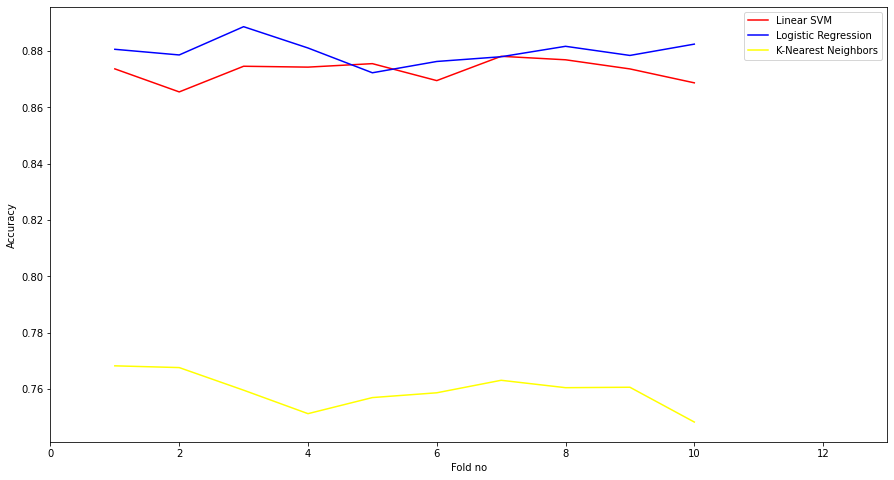

In [ ]:
X = X_train_CV.copy()
Y = y_train.copy()
classifier_names = ['Linear SVM',
                    'Logistic Regression',
                    'K-Nearest Neighbors',
                    'SGD Classifier',
                    "Rigde Classifier"]


classifiers = [LinearSVC(),
               LogisticRegression(),
               KNeighborsClassifier(3),]
plot_data=[]
name=[]
times = [1,2,3,4,5,6,7,8,9,10]
colors = ['red','blue','yellow']
clf_data=zip(classifier_names, classifiers, colors)
plt.figure(figsize= (15,8))
for clf_name, clf, cl in clf_data:
    print('Running '+clf_name)
    kf=StratifiedKFold(n_splits=10, shuffle=True)
    scores=cross_val_score(clf, X, Y, cv=kf)
    print(scores)
    plt.plot(times,scores, color = cl, markersize = 10)
    name.append(clf_name)
    plot_data.append(
        go.Scatter(
            x=[i+1 for i in range(10)],
            y=scores,
            mode='lines',
            name=clf_name
        )
    )
plt.xlim(0,13)
plt.legend(name, loc = 'upper right')

plt.xlabel('Fold no')
plt.ylabel('Accuracy')

### **5. Nhận xét :**
* 2 thuật toán SVM và Logistic Regression đều cho accuracy >= 0.85, chỉ riêng K-Neighbors thấp hơn rất nhiều nên sẽ không sử dụng để predict.
*
* Các model đều cho thấy accuracy của dữ liệu khi xử lý bằng CountVectorizer và TF-IDF Vectorizer đều tương đương nhau.
* Còn về Word2vec, vì việc xử lý quá lớn và do chưa tìm được thư viện từ vựng thích hợp nên chúng em không áp dụng.
* Như đã nói ở phía trước, việc mất cân bằng dữ liệu, cụ thể class 0 (báo chính thống) quá cáo khiến cho việc dự đoán class 0 dự đoán đúng rất nhiều và class 1 (scram) sai khá nhiều và bị lệch kha khá vào class 0 (Chúng ta có thể thấy qua bàng confusion matrix).

## **V. Nhận xét chung :**
1.   Về việc xây dựng với 6 trang đã thu thập từ trước, vì đây là bài toán Binary Classificationn nên các model mà nhóm chọn có kết quả tương đương nhau nhưng Logistic Regression có kết quả cao nhất (acc ~ 0.88), thấp nhất là K-Nearest Neighbors (acc ~ 0.74)
2. Trong quá trình thu thập, nhóm đã tăng số trang báo scram lên nhưng data vẫn bị lệch khiến cho dữ liệu mất cân bằng nhưng nhìn chung accuracy ở mức 0,8x vẫn chấp nhận được.



## **VI. Nguồn tham khảo :** [Github nhóm bạn Vinh](https://github.com/VinhPhamBG/CS114.L21/blob/main/Sarcasm_detection.ipynb?fbclid=IwAR2RZxnrmzgHeCywb7hGWMkdI7UjMVhtBlZsxmvGJ2U26vMYY1TkYJmmejI)